In [23]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [24]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [25]:
NUM_CLASSES = 10

# Dataset reading

In [26]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [27]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [29]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [30]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 42)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                860       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
Total params: 1180 (4.61 KB)
Trainable params: 1180 (4.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [32]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [33]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
51/53 [===========================>..] - ETA: 0s - loss: 2.2948 - accuracy: 0.1593
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
53/53 [==============================] - 2s 11ms/step - loss: 2.2938 - accuracy: 0.1588 - val_loss: 2.2232 - val_accuracy: 0.1973
Epoch 2/1000
42/53 [======================>.......] - ETA: 0s - loss: 2.1864 - accuracy: 0.1987

C:\Users\Mohamed Ashif\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/53 [============================>.] - ETA: 0s - loss: 2.1835 - accuracy: 0.2012
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
53/53 [==============================] - 0s 7ms/step - loss: 2.1833 - accuracy: 0.2013 - val_loss: 2.1079 - val_accuracy: 0.2054
Epoch 3/1000
45/53 [========================>.....] - ETA: 0s - loss: 2.1132 - accuracy: 0.2420
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
53/53 [==============================] - 0s 6ms/step - loss: 2.1059 - accuracy: 0.2435 - val_loss: 2.0102 - val_accuracy: 0.3200
Epoch 4/1000
46/53 [=========================>....] - ETA: 0s - loss: 2.0235 - accuracy: 0.2831
Epoch 4: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
53/53 [==============================] - 0s 6ms/step - loss: 2.0205 - accuracy: 0.2856 - val_loss: 1.9035 - val_accuracy: 0.3771
Epoch 5/1000
44/53 [=======================>......] - ETA: 0s - loss: 1.9425 - accuracy: 0.3120
Epoch 5: savin

In [34]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

18/18 [==============================] - 0s 3ms/step - loss: 0.6916 - accuracy: 0.8180


In [35]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [36]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 93ms/step
[2.24561766e-01 1.50571493e-02 5.17026901e-01 1.54034365e-02
 2.16030732e-01 3.71474540e-04 9.46539827e-03 1.93474477e-03
 1.48257794e-04 1.09942242e-07]
2


# Confusion matrix

70/70 [==============================] - 0s 2ms/step


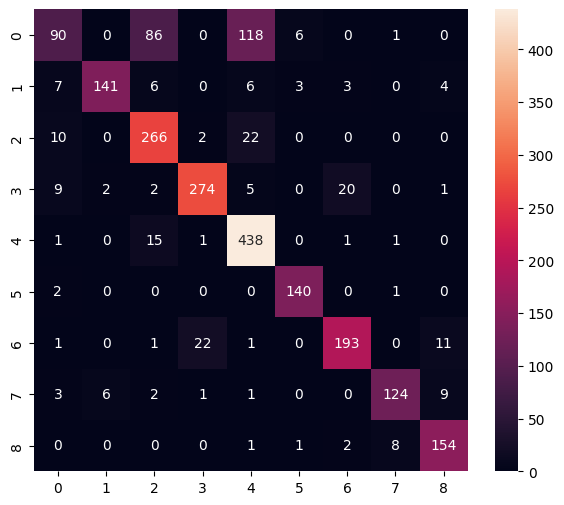

Classification Report
              precision    recall  f1-score   support

           0       0.73      0.30      0.42       301
           1       0.95      0.83      0.88       170
           2       0.70      0.89      0.78       300
           3       0.91      0.88      0.89       313
           4       0.74      0.96      0.84       457
           5       0.93      0.98      0.96       143
           6       0.88      0.84      0.86       229
           7       0.92      0.85      0.88       146
           8       0.86      0.93      0.89       166

    accuracy                           0.82      2225
   macro avg       0.85      0.83      0.82      2225
weighted avg       0.82      0.82      0.80      2225



In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [38]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

C:\Users\Mohamed Ashif\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\MOHAME~1\AppData\Local\Temp\tmpp2amxadq\assets


INFO:tensorflow:Assets written to: C:\Users\MOHAME~1\AppData\Local\Temp\tmpp2amxadq\assets


6836

# Inference test

In [40]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [41]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [42]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [43]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [44]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.24561796e-01 1.50571493e-02 5.17027020e-01 1.54034439e-02
 2.16030657e-01 3.71474627e-04 9.46540479e-03 1.93474605e-03
 1.48257808e-04 1.09942256e-07]
2
